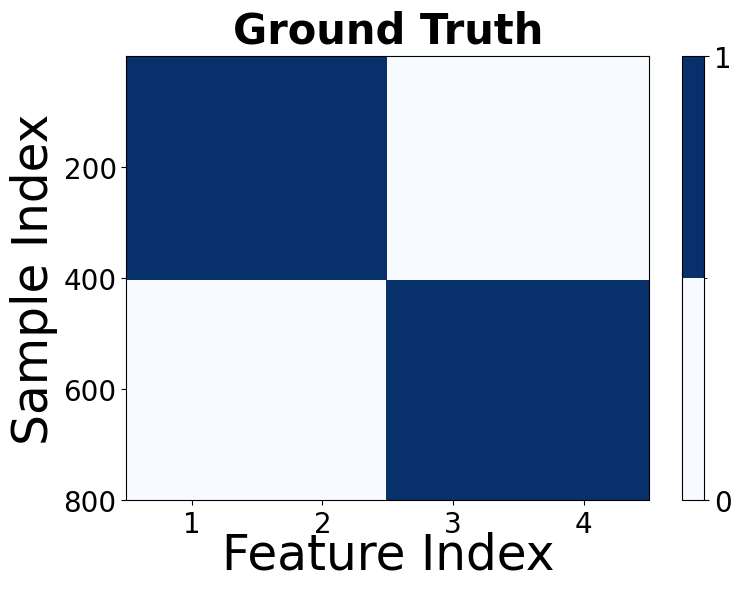

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os
import random

def set_seed(seed=42):
    # Python built-in
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Numpy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch CUDA (if using)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Or any other fixed seed


# ========== Define Helper Classes (Sigmoid, GatingNet, PredictNet, LSPIN) ==========

class HardSigmoid(nn.Module):
    def __init__(self, a):
        super().__init__()
        self.a = a

    def forward(self, x):
        return torch.clamp(self.a * x + 0.5, 0., 1.)

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, a, sigma):
        super().__init__()
        self.a = a
        self.sigma = sigma
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        self.hidden = nn.Sequential(*layers)
        self.alpha_layer = nn.Linear(last_dim, input_dim)
        self.hard_sigmoid = HardSigmoid(a)

    def forward(self, x, is_training=True):
        alpha = self.alpha_layer(self.hidden(x))
        if is_training:
            noise = torch.randn_like(alpha) * self.sigma
            z = alpha + noise
            gate = self.hard_sigmoid(z)
        else:
            gate = self.hard_sigmoid(alpha)
        return gate, alpha

class PredictionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class LSPIN(nn.Module):
    def __init__(self, input_dim, pred_hidden, output_dim, gate_hidden, a, sigma, lam, feature_selection=True):
        super().__init__()
        self.feature_selection = feature_selection
        self.a = a
        self.sigma = sigma
        self.lam = lam

        if self.feature_selection:
            self.gating_net = GatingNetwork(input_dim, gate_hidden, a, sigma)
        self.pred_net = PredictionNetwork(input_dim, pred_hidden, output_dim)
        self.loss_fn = nn.MSELoss()

    def forward(self, x, y=None, meta=None, compute_sim=False, train_gates=True):
        if self.feature_selection:
            gates, alpha = self.gating_net(x, is_training=train_gates)
            x = x * gates
        else:
            alpha = None

        logits = self.pred_net(x)
        output = {'logits': logits, 'alpha': alpha}

        if y is not None:
            loss_main = self.loss_fn(logits, y)
            output['loss'] = loss_main

        return output

    def get_prob_alpha(self, x):
        with torch.no_grad():
            _, alpha = self.gating_net(x, is_training=False)
            return self.gating_net.hard_sigmoid(alpha).cpu().numpy()

# ========== Define One-Hot Converter ==========

def convert_to_one_hot(vector, num_classes=None):
    vector = np.asarray(vector)
    if num_classes is None:
        num_classes = np.max(vector) + 1
    result = np.zeros((len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(np.float32)

# ========== Continue with synthetic data setup ==========

def linear_simple_data_gen(n_sample=500, seed=42):
    rng = np.random.default_rng(seed)
    Xs1 = rng.normal(loc=1, scale=0.5, size=(n_sample, 4))
    Ys1 = -2 * Xs1[:, 0] + Xs1[:, 1]
    Xs2 = rng.normal(loc=-1, scale=0.5, size=(n_sample, 4))
    Ys2 = Xs2[:, 2] - 2 * Xs2[:, 3]
    X_data = np.concatenate((Xs1, Xs2), axis=0)
    Y_data = np.concatenate((Ys1.reshape(-1, 1), Ys2.reshape(-1, 1)), axis=0)
    Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())
    labels = np.concatenate((np.ones(n_sample), np.full(n_sample, 2)))
    Y_data = np.concatenate((Y_data, labels.reshape(-1, 1)), axis=1)
    return X_data.astype(np.float32), Y_data.astype(np.float32)

# Generate and split
X_data, Y_data = linear_simple_data_gen()
X_train, X_remain, yc_train, yc_remain = train_test_split(X_data, Y_data, train_size=0.8, shuffle=True, random_state=42)
X_valid, X_test, yc_valid, yc_test = train_test_split(X_remain, yc_remain, train_size=0.5, shuffle=True, random_state=42)

y_train = yc_train[:, 0:1]
y_valid = yc_valid[:, 0:1]
y_test = yc_test[:, 0:1]

train_label = yc_train[:, 1]
valid_label = yc_valid[:, 1]
test_label = yc_test[:, 1]

# Ground truth feature map
ref_feat_mat_train = np.array([[1, 1, 0, 0] if lbl == 1 else [0, 0, 1, 1] for lbl in train_label])
ref_feat_mat_test = np.array([[1, 1, 0, 0] if lbl == 1 else [0, 0, 1, 1] for lbl in test_label])

import matplotlib.pyplot as plt
from matplotlib import cm, colors

cmap = cm.Blues
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

fig, axes = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(8, 6))
sorted_order = np.concatenate((np.where(train_label == 1)[0], np.where(train_label == 2)[0]))
im1 = axes.imshow(ref_feat_mat_train[sorted_order, :].astype(int), aspect='auto', cmap=cmap, norm=norm)
axes.set_title("Ground Truth", fontsize=title_size, fontweight="bold", pad=title_pad)
axes.set_ylabel("Sample Index", fontsize=ylabel_size)
axes.set_yticks([200, 400, 600, 800])
axes.set_yticklabels([200, 400, 600, 800], fontsize=ytick_size)
axes.set_xticks(list(range(4)))
axes.set_xticklabels(list(range(1, 5)), fontsize=xtick_size)
axes.set_xlabel("Feature Index", fontsize=xlabel_size, labelpad=-5)
cbar = fig.colorbar(im1, ax=axes, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)
plt.tight_layout()

Epoch 500: train loss = 0.011021554, valid loss = 0.007244973
Epoch 1000: train loss = 0.005720735, valid loss = 0.003358525
Epoch 1500: train loss = 0.002978547, valid loss = 0.001350598
Epoch 2000: train loss = 0.001477874, valid loss = 0.000677599
Epoch 2500: train loss = 0.000933684, valid loss = 0.000433064
Epoch 3000: train loss = 0.000749241, valid loss = 0.000338485
Epoch 3500: train loss = 0.000433405, valid loss = 0.000263398
Epoch 4000: train loss = 0.000362238, valid loss = 0.000224158
Epoch 4500: train loss = 0.000316527, valid loss = 0.000201020
Epoch 5000: train loss = 0.000329325, valid loss = 0.000178030
Epoch 5500: train loss = 0.000257272, valid loss = 0.000160546
Epoch 6000: train loss = 0.000187750, valid loss = 0.000151324
Epoch 6500: train loss = 0.000182321, valid loss = 0.000147422
Epoch 7000: train loss = 0.000169485, valid loss = 0.000132684
Epoch 7500: train loss = 0.000232768, valid loss = 0.000124956
Epoch 8000: train loss = 0.000222034, valid loss = 0.000

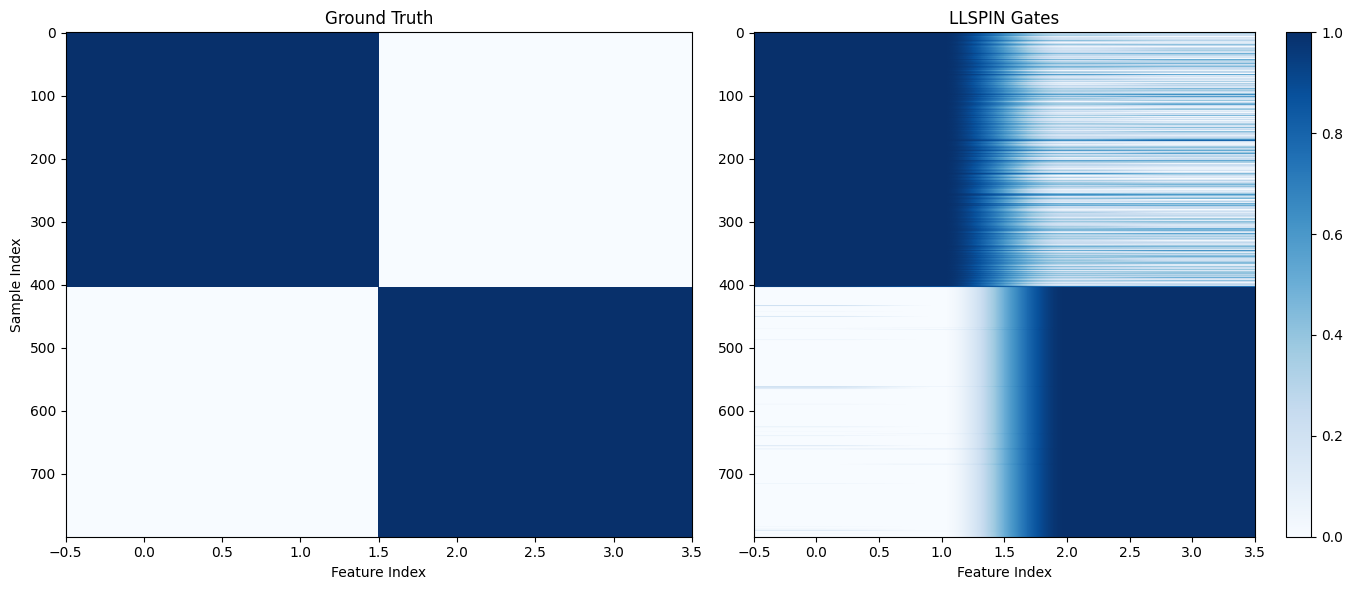

In [2]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_valid_tensor = torch.tensor(X_valid)
y_valid_tensor = torch.tensor(y_valid)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Define model with exact hyperparameters
model = LSPIN(
    input_dim=4,
    pred_hidden=[100, 100, 10],
    output_dim=1,
    gate_hidden=[10],
    a=1,
    sigma=0.5,
    lam=5e-3,
    feature_selection=True
)

# Training parameters
lr = 1e-1
num_epochs = 10000
display_step = 500
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Train loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    output = model(X_train_tensor, y_train_tensor, train_gates=True)
    loss = output['loss']
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    if (epoch + 1) % display_step == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_valid_tensor, y_valid_tensor, train_gates=False)
            val_loss = val_output['loss'].item()
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}: train loss = {loss.item():.9f}, valid loss = {val_loss:.9f}")

# # Evaluate test set
# model.eval()
# with torch.no_grad():
#     test_output = model(X_test_tensor, y_test_tensor, train_gates=False)
#     y_pred = test_output['logits'].cpu().numpy()
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     print(f"Test MSE: {mse:.6f}")
#     print(f"Test R²: {r2:.6f}")

model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor, y_test_tensor, train_gates=False)
    y_pred = test_output['logits'].cpu().numpy()
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Optional: accuracy by rounding (regression thresholding at 0.5)
    acc = np.mean((y_pred > 0.5).astype(int) == (y_test > 0.5).astype(int))
    
    print(f"Test MSE: {mse:.6f}")
    print(f"Test R² : {r2:.6f}")
    print(f"Test Acc: {acc:.4f}")

# Get the gates for training set
gate_mat_train = model.get_prob_alpha(X_train_tensor)

# Plot ground truth vs LLSPIN gates
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap = cm.Blues
norm = colors.BoundaryNorm([0, 0.5, 1], cmap.N)

axes[0].imshow(ref_feat_mat_train[sorted_order], aspect='auto', cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("Feature Index")
axes[0].set_ylabel("Sample Index")

im2 = axes[1].imshow(gate_mat_train[sorted_order], aspect='auto', cmap=cmap)
axes[1].set_title("LLSPIN Gates")
axes[1].set_xlabel("Feature Index")

plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()

Training LLSPIN...
Epoch 100: train loss=0.038043, valid loss=0.001748
Epoch 200: train loss=0.025483, valid loss=0.001311
Epoch 300: train loss=0.012898, valid loss=0.000380
Epoch 400: train loss=0.006377, valid loss=0.000189
Epoch 500: train loss=0.003378, valid loss=0.000124
Epoch 600: train loss=0.003120, valid loss=0.000101
Epoch 700: train loss=0.001928, valid loss=0.000102
Epoch 800: train loss=0.001959, valid loss=0.000087
Epoch 900: train loss=0.001937, valid loss=0.000092
Epoch 1000: train loss=0.001833, valid loss=0.000094
Evaluating on test set...
Test MSE: 0.000111
Test R²: 0.996037


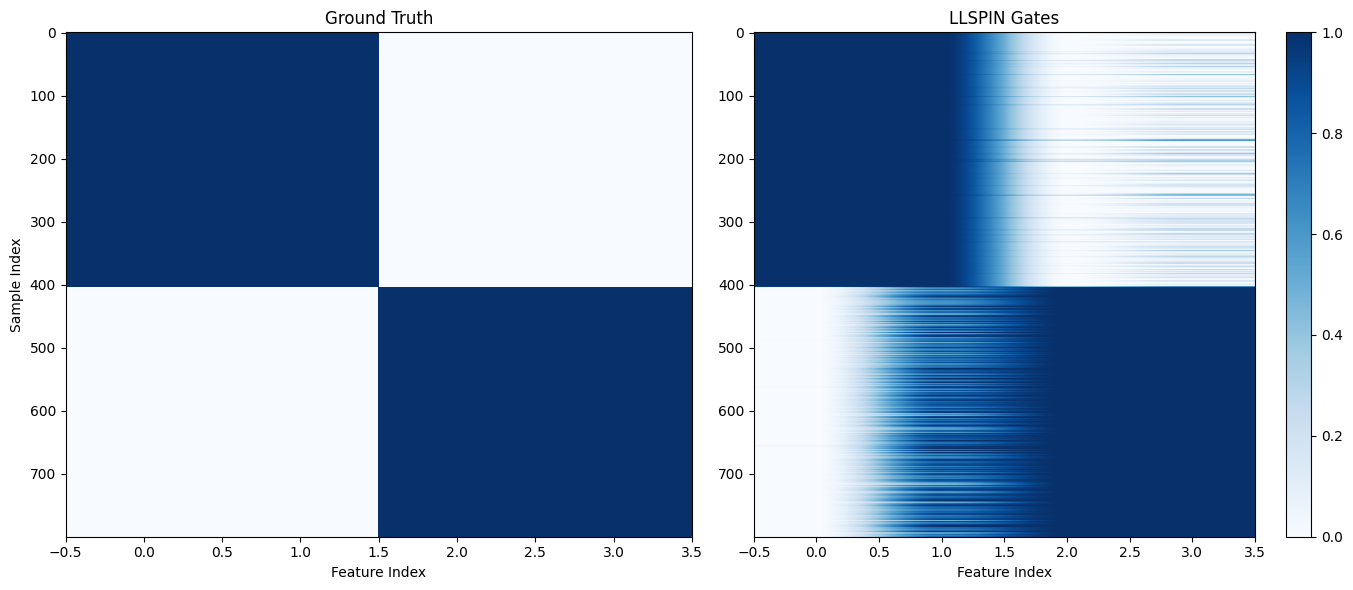

In [1]:
# llspin_pytorch.py
# Full 1-to-1 PyTorch implementation of the LLSPIN model

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# 1. Synthetic Data Generation
# -----------------------------
def linear_simple_data_gen(n_sample=500, seed=42):
    rng = np.random.default_rng(seed)
    Xs1 = rng.normal(loc=1, scale=0.5, size=(n_sample, 4))
    Ys1 = -2 * Xs1[:, 0] + Xs1[:, 1]
    Xs2 = rng.normal(loc=-1, scale=0.5, size=(n_sample, 4))
    Ys2 = Xs2[:, 2] - 2 * Xs2[:, 3]

    X_data = np.concatenate((Xs1, Xs2), axis=0)
    Y_data = np.concatenate((Ys1.reshape(-1, 1), Ys2.reshape(-1, 1)), axis=0)
    Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())
    labels = np.concatenate((np.ones(n_sample), np.full(n_sample, 2)))
    Y_data = np.concatenate((Y_data, labels.reshape(-1, 1)), axis=1)
    return X_data.astype(np.float32), Y_data.astype(np.float32)

# ----------------------
# 2. LLSPIN Components
# ----------------------
class HardSigmoid(nn.Module):
    def __init__(self, a):
        super().__init__()
        self.a = a

    def forward(self, x):
        return torch.clamp(self.a * x + 0.5, 0., 1.)

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, a, sigma):
        super().__init__()
        self.a = a
        self.sigma = sigma
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        self.hidden = nn.Sequential(*layers)
        self.alpha_layer = nn.Linear(last_dim, input_dim)
        self.hard_sigmoid = HardSigmoid(a)

    def forward(self, x, is_training=True):
        alpha = self.alpha_layer(self.hidden(x))
        if is_training:
            noise = torch.randn_like(alpha) * self.sigma
            z = alpha + noise
            gate = self.hard_sigmoid(z)
        else:
            gate = self.hard_sigmoid(alpha)
        return gate, alpha

class PredictionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class LSPIN(nn.Module):
    def __init__(self, input_dim, pred_hidden, output_dim, gate_hidden, a, sigma, lam, feature_selection=True):
        super().__init__()
        self.feature_selection = feature_selection
        self.a = a
        self.sigma = sigma
        self.lam = lam
        if self.feature_selection:
            self.gating_net = GatingNetwork(input_dim, gate_hidden, a, sigma)
        self.pred_net = PredictionNetwork(input_dim, pred_hidden, output_dim)
        self.loss_fn = nn.MSELoss()

    def forward(self, x, y=None, train_gates=True):
        if self.feature_selection:
            gates, alpha = self.gating_net(x, is_training=train_gates)
            x = x * gates
        else:
            alpha = None
        logits = self.pred_net(x)
        output = {'logits': logits, 'alpha': alpha}
        if y is not None:
            output['loss'] = self.loss_fn(logits, y)
        return output

    def get_prob_alpha(self, x):
        with torch.no_grad():
            _, alpha = self.gating_net(x, is_training=False)
            return self.gating_net.hard_sigmoid(alpha).cpu().numpy()

# ----------------------------
# 3. Training and Evaluation
# ----------------------------
def run_llspin():
    X_data, Y_data = linear_simple_data_gen()
    X_train, X_remain, yc_train, yc_remain = train_test_split(X_data, Y_data, train_size=0.8, random_state=42)
    X_valid, X_test, yc_valid, yc_test = train_test_split(X_remain, yc_remain, train_size=0.5, random_state=42)

    y_train = yc_train[:, 0:1]
    y_valid = yc_valid[:, 0:1]
    y_test = yc_test[:, 0:1]
    train_label = yc_train[:, 1]

    train_tensor = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

    model = LSPIN(
        input_dim=4,
        pred_hidden=[100, 100, 10],
        output_dim=1,
        gate_hidden=[10],
        a=1,
        sigma=0.5,
        lam=5e-3
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

    print("Training LLSPIN...")
    for epoch in range(1000):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            output = model(xb, yb, train_gates=True)
            loss = output['loss']
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_out = model(torch.tensor(X_valid), torch.tensor(y_valid), train_gates=False)
                print(f"Epoch {epoch+1}: train loss={total_loss:.6f}, valid loss={val_out['loss'].item():.6f}")

    print("Evaluating on test set...")
    model.eval()
    with torch.no_grad():
        pred = model(torch.tensor(X_test))['logits'].numpy()
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        print(f"Test MSE: {mse:.6f}")
        print(f"Test R²: {r2:.6f}")

    gate_mat_train = model.get_prob_alpha(torch.tensor(X_train))
    ref_feat_mat_train = np.array([[1, 1, 0, 0] if lbl == 1 else [0, 0, 1, 1] for lbl in train_label])
    sorted_order = np.concatenate((np.where(train_label == 1)[0], np.where(train_label == 2)[0]))

    # Plot ground truth vs LLSPIN gates
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    cmap = cm.Blues
    norm = colors.BoundaryNorm([0, 0.5, 1], cmap.N)

    axes[0].imshow(ref_feat_mat_train[sorted_order], aspect='auto', cmap=cmap, norm=norm)
    axes[0].set_title("Ground Truth")
    axes[0].set_xlabel("Feature Index")
    axes[0].set_ylabel("Sample Index")

    im2 = axes[1].imshow(gate_mat_train[sorted_order], aspect='auto', cmap=cmap)
    axes[1].set_title("LLSPIN Gates")
    axes[1].set_xlabel("Feature Index")

    plt.colorbar(im2, ax=axes[1])
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_llspin()
